<a href="https://colab.research.google.com/github/ChisengaSol/pytorch_traffic_signs_recognition/blob/main/traffic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load the Dataset

In [7]:
!pip install -q kaggle
from google.colab import files
import zipfile
from pathlib import Path
import os

drive_kaggle_path = "/content/kaggle.json"

#destination path for Kaggle API
dest_kaggle_dir = "/root/.kaggle"
dest_kaggle_path = os.path.join(dest_kaggle_dir, "kaggle.json")

if os.path.exists(drive_kaggle_path):
    os.makedirs(dest_kaggle_dir, exist_ok=True)

    # Copy the file
    !cp "{drive_kaggle_path}" "{dest_kaggle_path}"

    #set the correct permissions
    !chmod 600 "{dest_kaggle_path}"
    print("kaggle.json copied from Google Drive to ~/.kaggle/")
else:
    print("Error: kaggle.json not found in Google Drive at:", drive_kaggle_path)

kaggle.json copied from Google Drive to ~/.kaggle/


In [8]:
from pathlib import Path
import zipfile
import os

data_path = Path('data/')
dataset_name = "meowmeowmeowmeowmeow/gtsrb-german-traffic-sign"
kaggle_zip_name = "gtsrb-german-traffic-sign.zip"
zip_path = data_path / kaggle_zip_name
extracted_path = data_path / "gtsrb"

# create directory if it doesn't exist
data_path.mkdir(parents=True, exist_ok=True)

if extracted_path.is_dir():
    print(f"{extracted_path} already exists. Skipping download.")
else:
    print(f"Downloading {dataset_name}...")
    !kaggle datasets download -d {dataset_name} -p {data_path} --force  # --force ensures fresh download

    # Check if download succeeded
    if zip_path.exists():
        print("Unzipping...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extracted_path)
        print(f"Dataset extracted to {extracted_path}")

        # Remove the zip file to save space
        os.remove(zip_path)
    else:
        print("Error: Download failed. Check Kaggle authentication or dataset name.")

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 97% 591M/612M [00:03<00:00, 233MB/s]
100% 612M/612M [00:03<00:00, 165MB/s]
Unzipping...
Dataset extracted to data/gtsrb


### Go through the Dataset

In [9]:
import os
def go_over_data(dir_path):
  """Go over dir path and return its content"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
go_over_data(extracted_path)

There are 6 directories and 3 images in 'data/gtsrb'.
There are 43 directories and 0 images in 'data/gtsrb/train'.
There are 0 directories and 2010 images in 'data/gtsrb/train/10'.
There are 0 directories and 300 images in 'data/gtsrb/train/39'.
There are 0 directories and 2070 images in 'data/gtsrb/train/38'.
There are 0 directories and 210 images in 'data/gtsrb/train/19'.
There are 0 directories and 540 images in 'data/gtsrb/train/28'.
There are 0 directories and 330 images in 'data/gtsrb/train/21'.
There are 0 directories and 240 images in 'data/gtsrb/train/41'.
There are 0 directories and 1200 images in 'data/gtsrb/train/18'.
There are 0 directories and 270 images in 'data/gtsrb/train/29'.
There are 0 directories and 689 images in 'data/gtsrb/train/33'.
There are 0 directories and 240 images in 'data/gtsrb/train/32'.
There are 0 directories and 780 images in 'data/gtsrb/train/31'.
There are 0 directories and 390 images in 'data/gtsrb/train/22'.
There are 0 directories and 1440 imag

In [10]:
train_dir = extracted_path / 'Train'
test_dir = extracted_path / 'Test'
train_dir, test_dir

(PosixPath('data/gtsrb/Train'), PosixPath('data/gtsrb/Test'))

In [11]:
#visualize an image
import random
from PIL import Image


image_path_list = list(extracted_path.glob('*/*/*.png'))

#pick random image path
random_image_path = random.choice(image_path_list)

#get image class from path name(image class is folder name)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

#print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Random image path: data/gtsrb/Train/33/00033_00022_00008.png
Image class: 33
Image height: 27
Image width: 27


**Define Transforms**

In [12]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Create Dataset Class

In [13]:
from torchvision.datasets import ImageFolder

full_dataset = ImageFolder(train_dir, transform=None)

In [14]:
from sklearn.model_selection import train_test_split
import numpy as np

# Extract labels for stratification
labels = [label for _, label in full_dataset]

# Create array of indices [0, 1, 2, ...]
indices = np.arange(len(labels))

# Split indices
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

### Create train set and validation set

In [15]:
from torch.utils.data import Subset

# Wrap subsets with transforms
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)

class TransformedSubset:
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        #get the actual dataset index
        dataset_idx = self.indices[idx]

        #get image and label from original dataset
        image, label = self.dataset[dataset_idx]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.indices)

In [16]:
train_dataset = TransformedSubset(full_dataset, train_idx, train_transform)
val_dataset = TransformedSubset(full_dataset, val_idx, val_transform)

**Let us display some random images**

In [17]:
import matplotlib.pyplot as plt

In [18]:
def display_random_images(dataset,
                          classes,
                          n,
                          display_shape = True,
                          seed = None):

  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldnt be larger than 10. Setting to 10 and removing shape display.")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)


  plt.figure(figsize=(16,8))

  for i, target_sample in enumerate(random_samples_idx):
    target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]

    target_image_adjust = target_image.permute(1,2,0)

    plt.subplot(1,n,i+1)
    plt.imshow(target_image_adjust)
    plt.axis(False)

    if classes:
      title = f"Classes: {classes[target_label]}"
      if display_shape:
        title = title + f"\nshape: {target_image_adjust.shape}"
    plt.title(title)

In [19]:
classes = full_dataset.classes

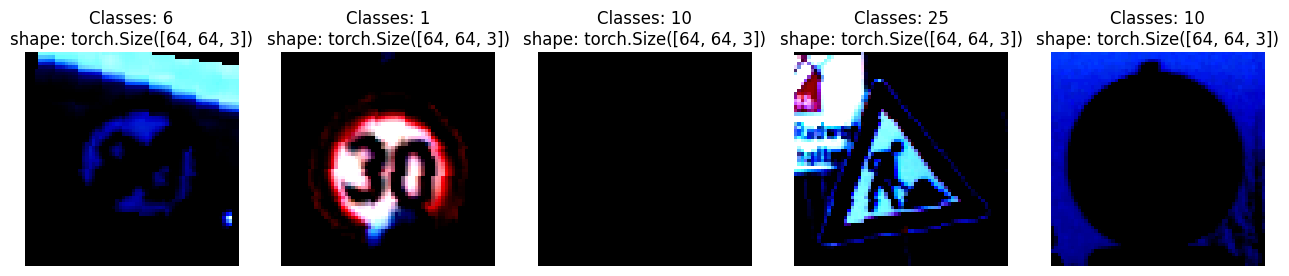

In [20]:
display_random_images(dataset=train_dataset, classes=classes,n=5)

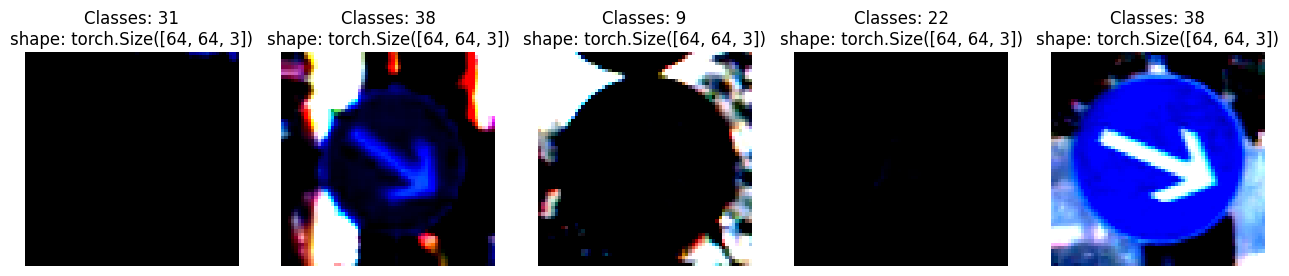

In [21]:
display_random_images(dataset=val_dataset, classes=classes,n=5)

### Create DataLoaders

In [22]:
from torch.utils.data import DataLoader

In [23]:
#create your transformed datasets
train_dataset = TransformedSubset(full_dataset, train_idx, train_transform)
val_dataset = TransformedSubset(full_dataset, val_idx, val_transform)

In [24]:
BATCH_SIZE = 32

**We get a subset of samples from the dataset and use it to train the models**

In [25]:
small_train_indices = train_idx[:2000]
small_val_indices = val_idx[:500]

In [26]:
small_train_dataset = TransformedSubset(full_dataset, small_train_indices, train_transform)
small_val_dataset = TransformedSubset(full_dataset, small_val_indices, val_transform)

In [27]:
#Verify output type as torch.Tensor
sample, label = small_train_dataset[0]
print(type(sample))

<class 'torch.Tensor'>


In [28]:
# Create DataLoaders
small_train_loader = DataLoader(small_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
small_val_loader = DataLoader(small_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Build Models

In [29]:
import torch
from torch import nn, optim
from tqdm.auto import tqdm

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()

In [31]:
#define a baseline model

class TrafficSignsRecognitionModel(nn.Module):
  def __init__(self,in_features:int,hidden_units:int,out_features:int):
    super().__init__()
    self.layers_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=in_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=out_features),
    )

  def forward(self, x):
    x = self.layers_stack(x)
    return x

In [32]:
model0 = TrafficSignsRecognitionModel(in_features=4096*3,hidden_units=10,out_features=len(full_dataset.classes))

**try a sample image on the model**

In [33]:
sample_img, label = small_train_dataset[0]

In [34]:
sample_img = sample_img.unsqueeze(0)

In [35]:
model0.eval()
model0.to(device)
with torch.inference_mode():
  logits = model0(sample_img.to(device))

torch.argmax(logits,dim=1)

tensor([20], device='cuda:0')

### Define Helper Functions to Train and Evaluate the models

In [36]:
def train_func(model, loss_fn, optimizer, train_dataloader, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total_samples = 0
    model.to(device)

    #Add progress bar for batches
    progress_bar = tqdm(train_dataloader, desc="Training", leave=False)
    for batch, (X, y) in enumerate(progress_bar):
        X, y = X.to(device), y.to(device)

        #Forward pass
        logits = model(X)
        loss = loss_fn(logits, y)

        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        train_loss += loss.item()
        y_pred = torch.argmax(logits, dim=1)
        correct += (y_pred == y).sum().item()
        total_samples += y.size(0)

        # Update progress bar description
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': (y_pred == y).float().mean().item()
        })

    train_loss /= len(train_dataloader)
    train_acc = (correct / total_samples) * 100
    return train_loss, train_acc


def test_func(model, loss_fn, test_dataloader, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total_samples = 0
    model.to(device)

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            logits = model(X)
            loss = loss_fn(logits, y)

            # Calculate metrics
            test_loss += loss.item()
            y_pred = torch.argmax(logits, dim=1)
            correct += (y_pred == y).sum().item()
            total_samples += y.size(0)

    test_loss /= len(test_dataloader)
    test_acc = (correct / total_samples) * 100
    return test_loss, test_acc

def train_and_plot(model,loss_fn,train_loader, val_loader,optimizer,device,epochs=15):
    """
      Train a model and plot the training/validation metrics.
    """

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    #main training loop with outer progress bar
    for epoch in tqdm(range(epochs), desc="Epochs"):
        print(f"\nEpoch: {epoch + 1}\n------------------------------")
        train_loss, train_acc = train_func(model, loss_fn, optimizer, train_loader, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        #Test
        test_loss, test_acc = test_func(model, loss_fn, val_loader, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"Train Loss: {train_loss:.5f}, Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

    print("Done")

    #Plotting
    plt.figure(figsize=(12, 5))

    #Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return the metrics
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies
    }

### train baseline model on smaller dataset

In [37]:
optimizer0 = optim.Adam(params=model0.parameters(),lr=0.001)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 1
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 3.91910, Train Accuracy: 2.85% | Test Loss: 3.82805, Test Accuracy: 5.60%

Epoch: 2
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 3.59397, Train Accuracy: 9.60% | Test Loss: 3.38475, Test Accuracy: 11.60%

Epoch: 3
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 3.22019, Train Accuracy: 15.15% | Test Loss: 3.21662, Test Accuracy: 13.60%

Epoch: 4
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 2.99439, Train Accuracy: 18.45% | Test Loss: 3.01281, Test Accuracy: 19.40%

Epoch: 5
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 2.86336, Train Accuracy: 19.75% | Test Loss: 2.94980, Test Accuracy: 18.60%

Epoch: 6
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 2.71028, Train Accuracy: 22.90% | Test Loss: 2.76277, Test Accuracy: 18.80%

Epoch: 7
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 2.61423, Train Accuracy: 26.60% | Test Loss: 2.67666, Test Accuracy: 23.40%

Epoch: 8
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 2.50907, Train Accuracy: 28.00% | Test Loss: 2.66013, Test Accuracy: 20.40%

Epoch: 9
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 2.41392, Train Accuracy: 29.95% | Test Loss: 2.58823, Test Accuracy: 28.40%

Epoch: 10
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 2.30017, Train Accuracy: 31.15% | Test Loss: 2.46950, Test Accuracy: 28.80%

Epoch: 11
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 2.21693, Train Accuracy: 32.85% | Test Loss: 2.54372, Test Accuracy: 28.00%

Epoch: 12
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 2.27497, Train Accuracy: 31.85% | Test Loss: 2.33436, Test Accuracy: 30.40%

Epoch: 13
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 2.00130, Train Accuracy: 37.95% | Test Loss: 2.20265, Test Accuracy: 36.20%

Epoch: 14
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 2.07750, Train Accuracy: 37.50% | Test Loss: 2.13911, Test Accuracy: 37.40%

Epoch: 15
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.96404, Train Accuracy: 39.95% | Test Loss: 2.13835, Test Accuracy: 36.40%
Done


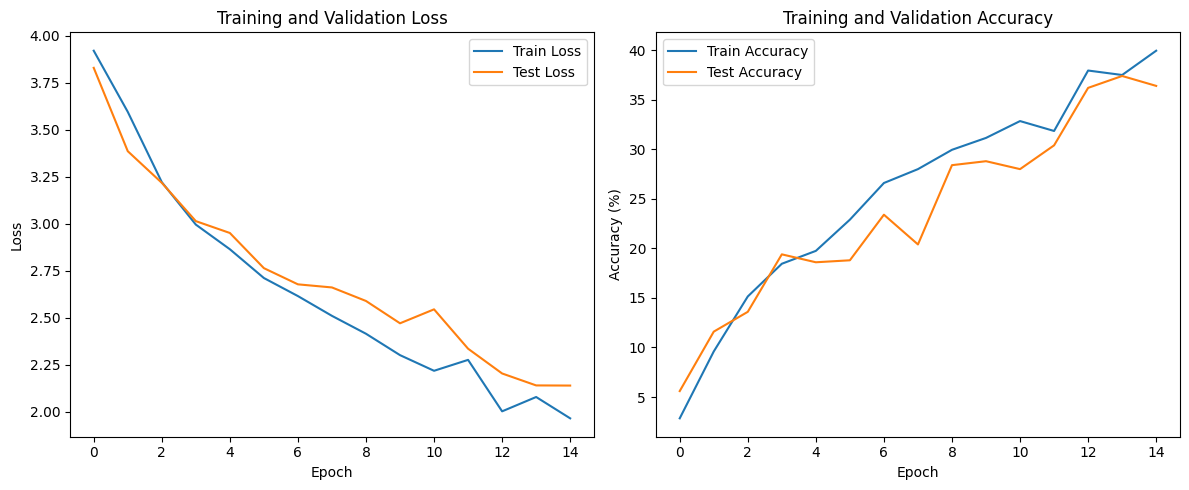

{'train_losses': [3.9191027520194885,
  3.593966639231122,
  3.220192621624659,
  2.9943867486620706,
  2.863356976282029,
  2.7102774287027027,
  2.614229845622229,
  2.5090680084531267,
  2.4139240544939797,
  2.3001706808332414,
  2.216926485773117,
  2.274967146298242,
  2.001299598860362,
  2.077495563597906,
  1.964037987920973],
 'train_accuracies': [2.85,
  9.6,
  15.15,
  18.45,
  19.75,
  22.900000000000002,
  26.6,
  28.000000000000004,
  29.95,
  31.15,
  32.85,
  31.85,
  37.95,
  37.5,
  39.95],
 'test_losses': [3.8280471712350845,
  3.3847487568855286,
  3.216620549559593,
  3.01280777156353,
  2.9498025327920914,
  2.762765944004059,
  2.6766610741615295,
  2.6601308286190033,
  2.5882276445627213,
  2.4694970473647118,
  2.5437165647745132,
  2.334364041686058,
  2.202651098370552,
  2.1391097977757454,
  2.1383462250232697],
 'test_accuracies': [5.6000000000000005,
  11.600000000000001,
  13.600000000000001,
  19.400000000000002,
  18.6,
  18.8,
  23.400000000000002,


In [38]:
train_and_plot(model0,loss_fn,small_train_loader, small_val_loader,optimizer0,device,epochs=15)

### Use a resnet pretrained model on the smaller dataset

In [39]:
from torchvision.models import resnet18

In [40]:
model1 = resnet18(weights='DEFAULT')
model1.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
optimizer1 = optim.Adam(params=model1.parameters(),lr=0.001)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 1
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 3.13561, Train Accuracy: 33.85% | Test Loss: 1.57481, Test Accuracy: 49.20%

Epoch: 2
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.34815, Train Accuracy: 57.85% | Test Loss: 1.63597, Test Accuracy: 50.80%

Epoch: 3
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.86473, Train Accuracy: 72.85% | Test Loss: 0.89330, Test Accuracy: 72.20%

Epoch: 4
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.61963, Train Accuracy: 80.45% | Test Loss: 0.65427, Test Accuracy: 78.00%

Epoch: 5
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.40915, Train Accuracy: 87.00% | Test Loss: 0.48087, Test Accuracy: 85.40%

Epoch: 6
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.38416, Train Accuracy: 88.60% | Test Loss: 0.40282, Test Accuracy: 86.00%

Epoch: 7
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.29003, Train Accuracy: 90.85% | Test Loss: 0.68727, Test Accuracy: 80.40%

Epoch: 8
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.29976, Train Accuracy: 91.95% | Test Loss: 0.33130, Test Accuracy: 89.20%

Epoch: 9
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.26330, Train Accuracy: 92.20% | Test Loss: 0.48770, Test Accuracy: 85.60%

Epoch: 10
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.21782, Train Accuracy: 93.35% | Test Loss: 0.47622, Test Accuracy: 85.00%

Epoch: 11
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.20751, Train Accuracy: 93.60% | Test Loss: 0.38684, Test Accuracy: 89.80%

Epoch: 12
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.13717, Train Accuracy: 95.80% | Test Loss: 0.34207, Test Accuracy: 90.20%

Epoch: 13
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.11223, Train Accuracy: 96.50% | Test Loss: 0.37114, Test Accuracy: 90.40%

Epoch: 14
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.12557, Train Accuracy: 96.10% | Test Loss: 0.28359, Test Accuracy: 91.60%

Epoch: 15
------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.11704, Train Accuracy: 96.60% | Test Loss: 0.28014, Test Accuracy: 92.60%
Done


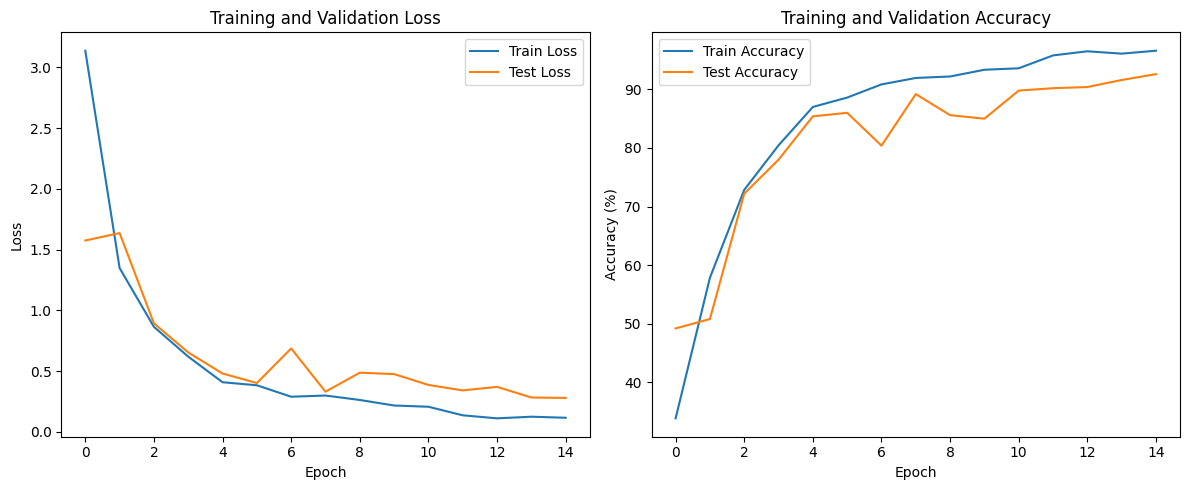

{'train_losses': [3.1356062378202165,
  1.348154624303182,
  0.8647329636982509,
  0.6196307341257731,
  0.4091498890211658,
  0.38415546005680445,
  0.29002802286829266,
  0.2997580115047712,
  0.2633013074537591,
  0.21781978111654993,
  0.20751238395533864,
  0.13717217012752025,
  0.11222785054558208,
  0.1255746652549576,
  0.1170421019455211],
 'train_accuracies': [33.85,
  57.85,
  72.85000000000001,
  80.45,
  87.0,
  88.6,
  90.85,
  91.95,
  92.2,
  93.35,
  93.60000000000001,
  95.8,
  96.5,
  96.1,
  96.6],
 'test_losses': [1.574805587530136,
  1.6359730660915375,
  0.893300749361515,
  0.6542662288993597,
  0.48087201081216335,
  0.402819087728858,
  0.6872670073062181,
  0.33130439394153655,
  0.48770049028098583,
  0.47621683683246374,
  0.3868364754598588,
  0.3420666572637856,
  0.3711424400098622,
  0.28359212214127183,
  0.28013568208552897],
 'test_accuracies': [49.2,
  50.8,
  72.2,
  78.0,
  85.39999999999999,
  86.0,
  80.4,
  89.2,
  85.6,
  85.0,
  89.8,
  90.2

In [42]:
train_and_plot(model1,loss_fn,small_train_loader, small_val_loader,optimizer1,device,epochs=15)

### Using the whole dataset with resnet18

In [43]:
model2 = resnet18(weights='DEFAULT')
model2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
optimizer2 = optim.Adam(params=model2.parameters(),lr=0.001)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 1
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.59673, Train Accuracy: 83.47% | Test Loss: 0.17671, Test Accuracy: 94.04%

Epoch: 2
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.16112, Train Accuracy: 95.11% | Test Loss: 0.18234, Test Accuracy: 94.75%

Epoch: 3
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.11463, Train Accuracy: 96.58% | Test Loss: 0.09715, Test Accuracy: 96.85%

Epoch: 4
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.09790, Train Accuracy: 97.15% | Test Loss: 0.07738, Test Accuracy: 98.00%

Epoch: 5
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.07719, Train Accuracy: 97.85% | Test Loss: 0.06610, Test Accuracy: 98.23%

Epoch: 6
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.07293, Train Accuracy: 98.00% | Test Loss: 0.06805, Test Accuracy: 98.07%

Epoch: 7
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.07705, Train Accuracy: 97.79% | Test Loss: 0.05006, Test Accuracy: 98.55%

Epoch: 8
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.05440, Train Accuracy: 98.48% | Test Loss: 0.03393, Test Accuracy: 98.84%

Epoch: 9
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.04230, Train Accuracy: 98.85% | Test Loss: 0.02707, Test Accuracy: 99.13%

Epoch: 10
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.05622, Train Accuracy: 98.37% | Test Loss: 0.02649, Test Accuracy: 99.07%

Epoch: 11
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.03506, Train Accuracy: 99.02% | Test Loss: 0.02656, Test Accuracy: 99.30%

Epoch: 12
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.04399, Train Accuracy: 98.78% | Test Loss: 0.02759, Test Accuracy: 99.13%

Epoch: 13
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.03193, Train Accuracy: 99.09% | Test Loss: 0.07764, Test Accuracy: 97.55%

Epoch: 14
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.03386, Train Accuracy: 99.02% | Test Loss: 0.01474, Test Accuracy: 99.60%

Epoch: 15
------------------------------


Training:   0%|          | 0/981 [00:00<?, ?it/s]

Train Loss: 0.03054, Train Accuracy: 99.14% | Test Loss: 0.01392, Test Accuracy: 99.52%
Done


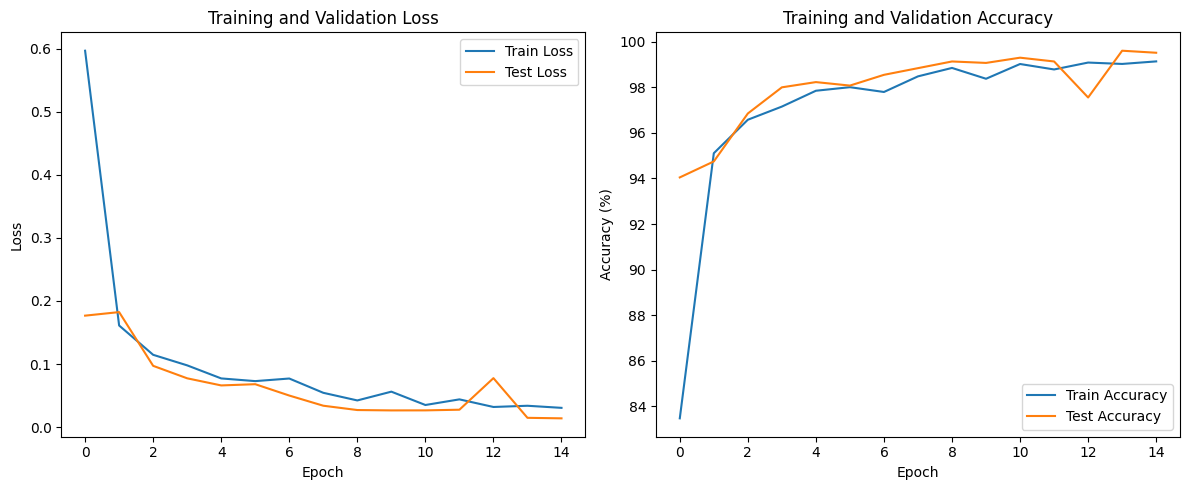

{'train_losses': [0.5967251812454377,
  0.16112010514246874,
  0.11462817927538849,
  0.09790075628178775,
  0.07719460922207566,
  0.07292672775696735,
  0.07704859537421488,
  0.054402498654700426,
  0.042295113980365326,
  0.056219553185182215,
  0.035064741927002964,
  0.04398968693982044,
  0.031933369217731745,
  0.033861591658576384,
  0.030544332868440237],
 'train_accuracies': [83.47307680045908,
  95.1063219306915,
  96.57601938342845,
  97.1530589473013,
  97.84805687505977,
  98.004272005611,
  97.79385978895017,
  98.47929352504224,
  98.84910893614308,
  98.37408741671183,
  99.0212643861383,
  98.78215959447827,
  99.08502566391431,
  99.0244524500271,
  99.1360346861351],
 'test_losses': [0.1767140147950358,
  0.18234109810613355,
  0.09715272322849833,
  0.07737737533017669,
  0.06609685504847176,
  0.06804694694550179,
  0.05005768950502316,
  0.0339271913732017,
  0.027074853603035007,
  0.026488646188240626,
  0.02655633098876889,
  0.027593729618415157,
  0.0776402

In [45]:
train_and_plot(model2,loss_fn,train_loader, val_loader,optimizer2,device,epochs=15)

In [46]:
test_dir

PosixPath('data/gtsrb/Test')

In [47]:
test_images = list(test_dir.glob('*.png'))

In [48]:
import torchvision

In [49]:
test_images

[PosixPath('data/gtsrb/Test/00502.png'),
 PosixPath('data/gtsrb/Test/08039.png'),
 PosixPath('data/gtsrb/Test/11678.png'),
 PosixPath('data/gtsrb/Test/07457.png'),
 PosixPath('data/gtsrb/Test/01587.png'),
 PosixPath('data/gtsrb/Test/07014.png'),
 PosixPath('data/gtsrb/Test/04656.png'),
 PosixPath('data/gtsrb/Test/05660.png'),
 PosixPath('data/gtsrb/Test/08844.png'),
 PosixPath('data/gtsrb/Test/04015.png'),
 PosixPath('data/gtsrb/Test/08207.png'),
 PosixPath('data/gtsrb/Test/08290.png'),
 PosixPath('data/gtsrb/Test/02686.png'),
 PosixPath('data/gtsrb/Test/10718.png'),
 PosixPath('data/gtsrb/Test/07154.png'),
 PosixPath('data/gtsrb/Test/01185.png'),
 PosixPath('data/gtsrb/Test/00439.png'),
 PosixPath('data/gtsrb/Test/00696.png'),
 PosixPath('data/gtsrb/Test/10981.png'),
 PosixPath('data/gtsrb/Test/11665.png'),
 PosixPath('data/gtsrb/Test/00918.png'),
 PosixPath('data/gtsrb/Test/08244.png'),
 PosixPath('data/gtsrb/Test/10314.png'),
 PosixPath('data/gtsrb/Test/12287.png'),
 PosixPath('data

### Predict on custom image

In [51]:
traffic_signs = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}

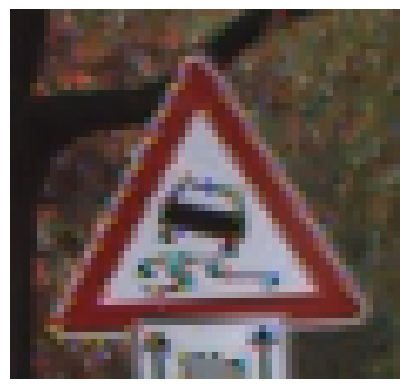

In [111]:
from PIL import Image

# Load image and apply transforms
custom_image = Image.open(test_images[6100])

plt.imshow(custom_image)
plt.axis('off')
plt.show()

In [112]:
transformed_image = val_transform(custom_image)

# Make prediction
model0.eval()
with torch.no_grad():
   prediction = model2(transformed_image.unsqueeze(0).to(device))
   predicted_class = torch.argmax(prediction, dim=1).item()

print(f"Predicted class: {predicted_class} => {traffic_signs[predicted_class]}")

Predicted class: 16 => Vehicles over 3.5 metric tons prohibited
